# Mixed Programing

In this tutorial we show how to combine NDArray and Symbol together to train a neural network from scratch. This mixed programming flavor is one of the unique feature that make MXNet different to other frameworks. 

## Training a Multi-layer Perception. 

We will use a two-layer perception as the example to show the idea. Note that the codes apply to other objective functions such as deep convolutional neural networks as well. We first define the network:

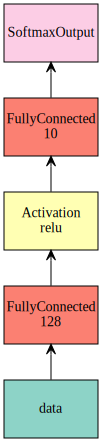

In [1]:
import mxnet as mx
num_classes = 10
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=num_classes)
net = mx.sym.SoftmaxOutput(data=net, name='out')
mx.viz.plot_network(net)

The free variables include the weight and the bias from each fully connected layer (`fc1` and `fc2`), the example for variable `data`, and the label for the softmax output `out`. We list all these variables' name by `list_argument`: 

In [2]:
print(net.list_arguments())

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'out_label']


To run forward and backward, we need to bind data to all free variables first. We can create all `NDArray`s and then bind them as we did on the [Symbol tutorial](./symbol.ipynb). There is also function named `simple_bind` that simplifies this procedure. This function first inferences the shapes of all free variables by using the provided data shape, and then allocate and bind data, which can be accessed by the attribute `arg_arrays` of the returned executor. 

In [6]:
num_features = 100
batch_size = 100
ex = net.simple_bind(ctx=mx.cpu(), data=(batch_size, num_features))
args = dict(zip(net.list_arguments(), ex.arg_arrays))
for name in args:
    print(name, args[name].shape)

('fc2_weight', (10L, 128L))
('fc1_weight', (128L, 100L))
('out_label', (100L,))
('fc2_bias', (10L,))
('data', (100L, 100L))
('fc1_bias', (128L,))


Change `ctx` to GPU we can let the arrays be allocated on GPU:

In [22]:
ex = net.simple_bind(ctx=mx.gpu(), data=(batch_size, num_features))
args = dict(zip(net.list_arguments(), ex.arg_arrays))
for name in args:
    print(name, args[name].shape, args[name].context)

('fc2_weight', (10L, 128L), gpu(0))
('fc1_weight', (128L, 100L), gpu(0))
('out_label', (100L,), gpu(0))
('fc2_bias', (10L,), gpu(0))
('data', (100L, 100L), gpu(0))
('fc1_bias', (128L,), gpu(0))


Then we initialize the weights by random values. 

In [23]:
for name in args:
    data = args[name]
    if 'weight' in name:
        data[:] = mx.random.uniform(-0.1, 0.1, data.shape)
    if 'bias' in name:
        data[:] = 0

Before training, we generate a synthetic dataset

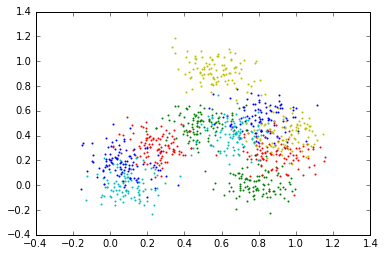

In [13]:
import numpy as np
import matplotlib.pyplot as plt
class ToyData:
    def __init__(self, num_classes, num_features):
        self.num_classes = num_classes
        self.num_features = num_features
        self.mu = np.random.rand(num_classes, num_features)
        self.sigma = np.ones((num_classes, num_features)) * 0.1
    def get(self, num_samples):
        num_cls_samples = num_samples / self.num_classes
        x = np.zeros((num_samples, self.num_features))
        y = np.zeros((num_samples, ))
        for i in range(self.num_classes):
            cls_samples = np.random.normal(self.mu[i,:], self.sigma[i,:], (num_cls_samples, self.num_features))
            x[i*num_cls_samples:(i+1)*num_cls_samples] = cls_samples
            y[i*num_cls_samples:(i+1)*num_cls_samples] = i
        return x, y
    def plot(self, x, y):
        colors = ['r', 'b', 'g', 'c', 'y']
        for i in range(self.num_classes):
            cls_x = x[y == i]
            plt.scatter(cls_x[:,0], cls_x[:,1], color=colors[i%5], s=1)
        plt.show()

toy_data = ToyData(num_classes, num_features)
x, y = toy_data.get(1000)
toy_data.plot(x,y)

Finally we can start the training. Here we use the plain minibatch stochastic gradient descent with fixed learning rate. For every 10 iterations we plot the accuracy. 

In [24]:
learning_rate = 0.1
for i in range(100):
    x, y = toy_data.get(batch_size)
    args['data'][:] = x
    args['out_label'][:] = y
    ex.forward(is_train=True)
    ex.backward()
    for weight, grad in zip(ex.arg_arrays, ex.grad_arrays):
        weight[:] -= learning_rate * (grad / batch_size)
    if i % 10 == 0:
        acc = (mx.nd.argmax_channel(ex.outputs[0]).asnumpy() == y).sum()
        print('iteration %d, accuracy %f' % (i, float(acc)/y.shape[0]))    

iteration 0, accuracy 0.210000
iteration 10, accuracy 0.990000
iteration 20, accuracy 1.000000
iteration 30, accuracy 1.000000
iteration 40, accuracy 1.000000
iteration 50, accuracy 1.000000
iteration 60, accuracy 1.000000
iteration 70, accuracy 1.000000
iteration 80, accuracy 1.000000
iteration 90, accuracy 1.000000


On this section we show how to use the imperative NDArray and symbolic Symbol together to implement a complete training algorithm. The former can be often used for

- data containers
- programs that requires flexibility, such as implementing the updating rules and monitoring the progress in optimization method
- implementing Symbol operators
- debugging such as printing and step-by-step execution

While the later can be used for defining the object function, which benefits from the heavy optimization placed on Symbol and auto differentation. 

## Data Parallelism with Multi-devices

On the [NDArray tutorial](./ndarray.ipynb) we mentioned that the backend system is able to automatically parallel the computations. It make developing parallel program as easy as writing serial programs. 

TODO